# Graph Machine Learning

**Node Classification**

**Amazon:** The Amazon Computersnetworks from the “Pitfalls of Graph Neural Network Evaluation” paper. Nodes represent goods and edges represent that two goods are frequently bought together. Given product reviews as bag-of-words node features, the task is to map goods to their respective product category.

The  network consists of 238.162 links.

**Objective** Classify Amazon product into one of the ten classes by performing .

### **1. Cargar Librerias**

In [1]:
import os
import pandas as pd
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 38.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## **2. Adquisicion de Datos**

Se importa la libreria el dataset "Amazon" de la Libreria Pytorch donde se eliminan los nodos aislados y se generan las estadisticas del grafo:

In [3]:
import torch
from torch_geometric.datasets import Amazon
from torch_geometric.transforms import RemoveIsolatedNodes

# Load the Amazon  dataset
dataset = Amazon(root='.', name='Photo')

# Get the first graph object from the dataset
data = dataset[0]

# Se excluyen los  nodos aislados
transform =  RemoveIsolatedNodes()

# Apply transformations
data = transform(data)

# Print dataset information
print("Number of nodes:", data.num_nodes)
print("Number of edges:", data.num_edges)
print("Node features shape:", data.x.shape)
print("Number of classes:", dataset.num_classes)


# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')


Processing...
Done!


Number of nodes: 7535
Number of edges: 238162
Node features shape: torch.Size([7535, 745])
Number of classes: 8

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


## **3. Visualización del Grafo**

Como se observa existen algunas conexiones de nodos que se encuentran separados del nodo principal:

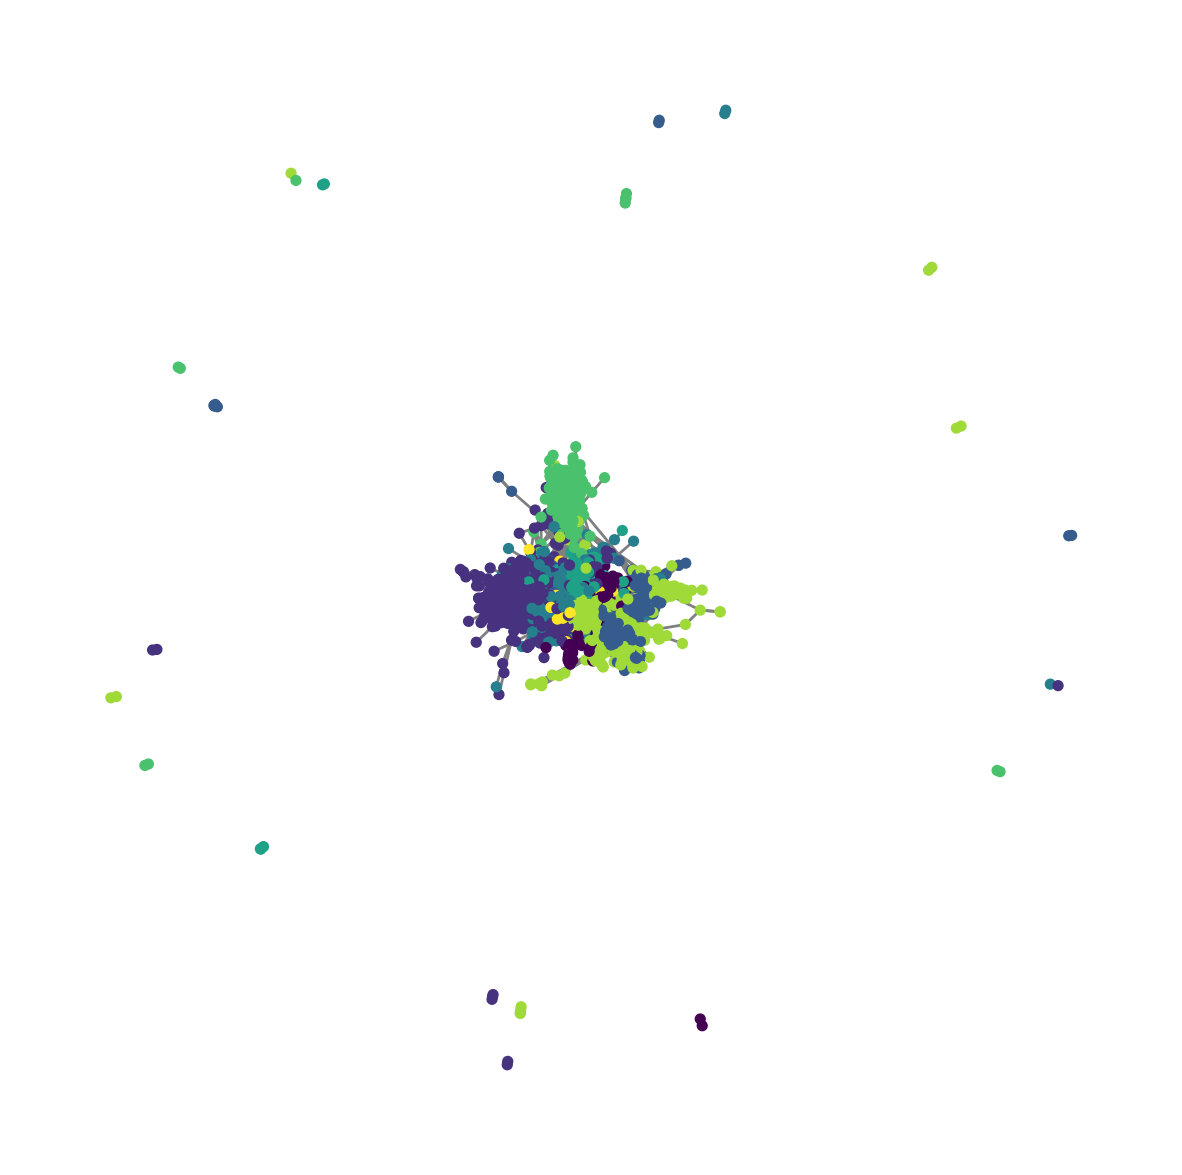

In [74]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(15,15))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=50,
                node_color=data.y,
                width=2,
                edge_color="grey"
                )
plt.title("Grafo Amazon - Productos de Fotografia")
plt.show()

Se identifica el Subgrafo principal del Dataset Amazon:

In [124]:
import networkx as nx

# Obtener todas las componentes conectadas del grafo
componentes = list(nx.connected_components(G))

# Seleccionar la componente más grande como el grafo principal
grafo_principal = max(componentes, key=len)

# Crear un subgrafo principal a partir del grafo original
subgrafo_principal = G.subgraph(grafo_principal)


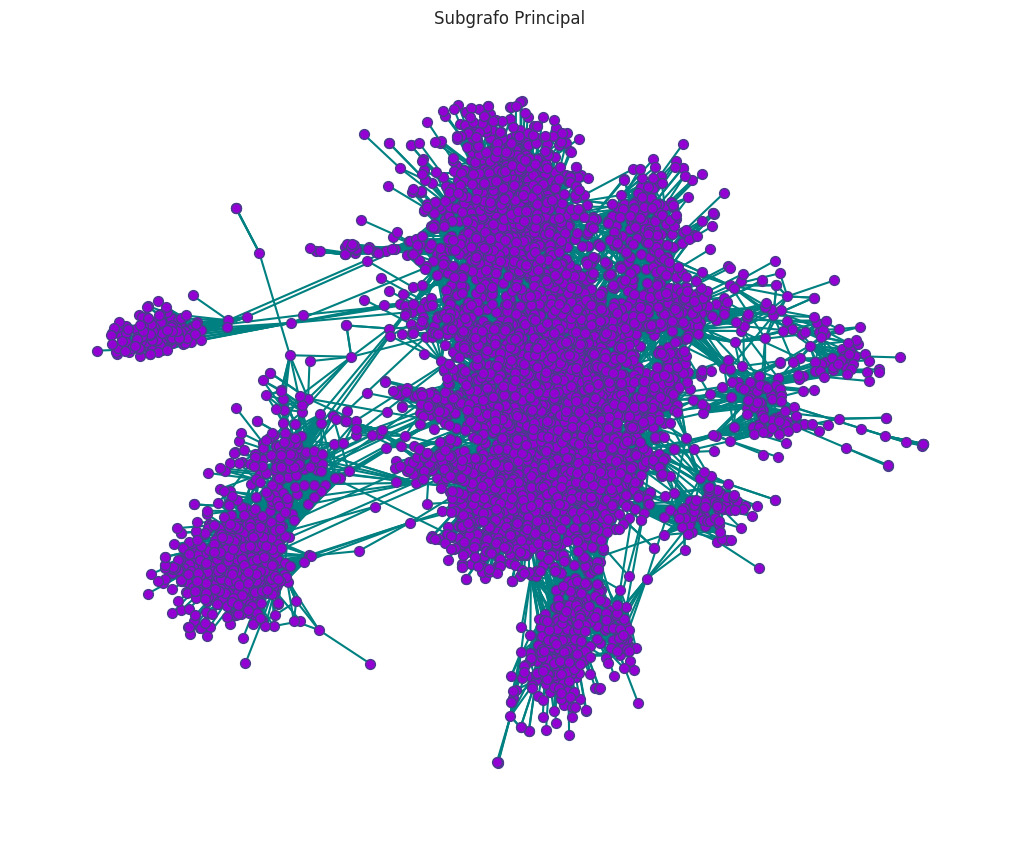

In [131]:
import matplotlib.pyplot as plt

# Graficar el subgrafo principal
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgrafo_principal, seed=42)
nx.draw(subgrafo_principal, pos, with_labels=False, node_size=50, node_color="darkviolet", edge_color='teal', width=1.5,edgecolors='darkslateblue')
plt.title('Subgrafo Principal')
plt.show()


### **3.1. Metricas del Grafo**

In [151]:
print(f"""

Propiedades globales del grafo
==============================

        - Degree medio: Número de conexiones medio de los nodos de un grafo.
                {((G.number_of_edges()*2) / G.number_of_nodes()):,.3}
        - Densidad del grafo: Número de conexiones / Número posible de conexiones.
                {nx.density(G)}
        - Otras medidas: Transitividad, Reciprocidad.
                {nx.transitivity(G)}
                {nx.algorithms.clustering(G)}

"""
)



Propiedades globales del grafo

        - Degree medio: Número de conexiones medio de los nodos de un grafo.
                8.88
        - Densidad del grafo: Número de conexiones / Número posible de conexiones.
                0.0013440399994224506
        - Otras medidas: Transitividad, Reciprocidad.
                0.07303569114446713
                {0: 0.3, 1: 0.2, 2: 0.6666666666666666, 3: 0.16363636363636364, 4: 0, 5: 0.047619047619047616, 6: 0.4722222222222222, 7: 0.027777777777777776, 8: 0.1111111111111111, 9: 0.1, 10: 0, 11: 0.01818181818181818, 12: 0.07272727272727272, 13: 0.24242424242424243, 14: 0.26666666666666666, 15: 0.19047619047619047, 16: 0.06666666666666667, 17: 0.07142857142857142, 18: 0.6666666666666666, 19: 0.12727272727272726, 20: 0.3333333333333333, 21: 0.014492753623188406, 22: 0.2, 23: 0.19444444444444445, 24: 0.08823529411764706, 25: 0.10606060606060606, 26: 0.07142857142857142, 27: 0.10714285714285714, 28: 0, 29: 0.06666666666666667, 30: 0.02777777777777

### **3.2. Analisis de la distribucion de las clases**

Como se observa las 8 clases del dataset tienen una participacion entre el 4.3% y el 25.4%

In [23]:
from collections import Counter
import pandas as pd

# Get the labels from the dataset
labels = dataset.data.y

# Count the occurrences of each label
label_counts = Counter(labels.numpy())

# Calculate the total number of samples
total_samples = len(labels)

# Create a list to store the results
results = []

# Calculate class distribution and percentage
for label, count in label_counts.items():
    percentage = (count / total_samples)
    results.append({'Class': label, 'Samples': count, 'proportion': percentage})

# Create a DataFrame from the results
df_agg_classes = pd.DataFrame(results)
df_agg_classes= df_agg_classes.sort_values(by='proportion', ascending=False)

# Print the DataFrame
df_agg_classes



/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


,Class,Samples,proportion
0,6,1941,0.253725
5,1,1686,0.220392
2,3,915,0.119608
1,4,882,0.115294
3,5,823,0.107582
4,2,703,0.091895
6,0,369,0.048235
7,7,331,0.043268


In [24]:
# Extract proportions from the DataFrame
proportions = df_agg_classes["proportion"].values.tolist()
proportions


[0.25372549019607843,
 0.2203921568627451,
 0.11960784313725491,
 0.11529411764705882,
 0.10758169934640523,
 0.0918954248366013,
 0.04823529411764706,
 0.04326797385620915]

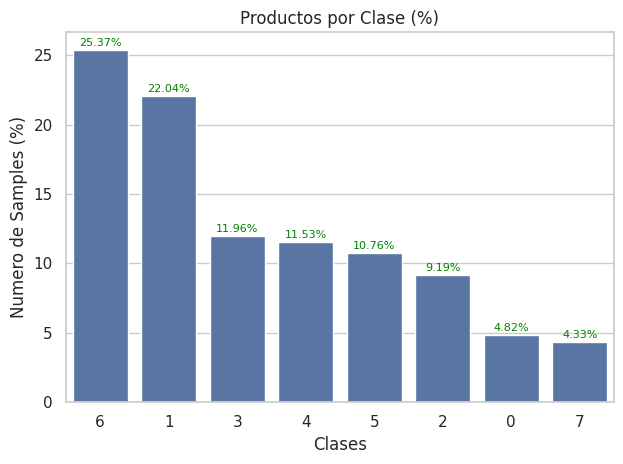

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_agg_classes is already defined and contains the class distribution information

# Set the seaborn style
sns.set(style="whitegrid")

# Create the bar plot using seaborn
ax = sns.barplot(
    x=df_agg_classes['Class'].astype(str),
    y=df_agg_classes['proportion'] * 100,  # multiplying by 100 to show percentages
)

# Add value labels on top of the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='Green', xytext=(0, 5),
                textcoords='offset points')

plt.title("Productos por Clase (%)")
plt.xlabel("Clases")
plt.ylabel("Numero de Samples (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



## **4. Separacion del dataset en "Train", "Validation" y "Test"**

Se realiza la separación del grafo con 70% en entrenamiento, 10% validacion y 20% en Test:

In [26]:
# Nodes
num_nodes = data.num_nodes
train_percentage = 0.7
num_train_nodes = int(train_percentage * num_nodes)

# labels
num_classes = torch.unique(data.y).size(0)
data.num_classes = num_classes

print("Nodes #:", num_nodes, "\nNodos en train #:", num_train_nodes, "\nClasses #:", num_classes)

Nodes #: 7535 
Nodos en train #: 5274 
Classes #: 8


In [27]:
# Create a boolean mask to indicate whether node is in training set
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[: num_train_nodes] = True

In [28]:
# Add train mask to data object
data.train_mask = train_mask

# Create test mask that is the inverse of train mask
test_mask = ~data.train_mask
data.test_mask = test_mask

data

Data(x=[7535, 745], edge_index=[2, 238162], y=[7535], num_classes=8, train_mask=[7535], test_mask=[7535], val_mask=[7535])

In [29]:
# Porcentaje de nodos para validación
val_percentage = 0.1

# Número de nodos para validación
num_val_nodes = int(val_percentage * num_train_nodes)

# Crear una máscara booleana para indicar qué nodos son de validación
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[num_train_nodes:num_train_nodes+num_val_nodes] = True

# Añadir la máscara de validación al objeto data
data.val_mask = val_mask

# Crear máscara de entrenamiento que sea la inversa de la máscara de validación
train_mask = ~(data.val_mask | data.test_mask)
data.train_mask = train_mask



In [30]:
# Mostrar información
print("validation nodes (#): ", num_val_nodes)

# Actualizar el número de nodos de entrenamiento
num_train_nodes = int(train_mask.sum().item())
print("Train nodes # (after validation split): ", num_train_nodes)

num_test_nodes = int(test_mask.sum().item())
print("Test nodes #(after validation split): ", num_test_nodes)

validation nodes (#):  527
Train nodes # (after validation split):  5274
Test nodes #(after validation split):  2261


## **5. Construccion de Modelos**

A continuacion se presentan los modelos desarrollados para realizar este ejercicio:

In [31]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv, GATConv, SAGEConv
import networkx as nx

In [32]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

In [33]:
def test(model, data, MLP=False):
    model.eval()
    if MLP:
      out = model(data.x)
    else:
      _, out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    # Count the number of predictions for each class
    class_counts = {}
    for class_label in range(data.num_classes):
        class_counts[class_label] = int((pred == class_label)[data.test_mask].sum())

    print(class_counts)

    test_acc = accuracy(pred[data.test_mask], data.y[data.test_mask])
    return test_acc

In [34]:
def history_plot(history, plot_name):
    epochs = history['epoch']
    training_loss = history['loss']
    validation_accuracy = history['test_acc']
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_loss, label='Training Loss', color='blue')
    plt.plot(epochs, validation_accuracy, label='Validation Accuracy', color='orange')

    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Value')

    plt.legend(loc='upper left')
    plt.savefig(plot_name)
    plt.show()

In [35]:
def train(model, data, epochs=10, plot=True, plot_name = "plot", MLP=False):
    weight = torch.tensor([1 / i for i in df_agg_classes["proportion"].values], dtype=torch.float)
    criterion = torch.nn.CrossEntropyLoss(weight=weight)
    optimizer = model.optimizer

    history = {
            'epoch': [],
            'loss': [],
            'test_acc': [],
            'outputs' : []
    }

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        if MLP:
          out = model(data.x)
        else:
          _, out = model(data.x, data.edge_index)

        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        history['epoch'].append(epoch)
        history['loss'].append(loss.item())
        history['test_acc'].append(val_acc)
        history['outputs'].append(out[data.train_mask].argmax(dim=1))

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    if plot:
        history_plot(history, plot_name)

    return model

In [36]:
def visualize(h, color):
  z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

  plt.figure(figsize=(8, 5))
  plt.xticks([])
  plt.yticks([])

  plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="viridis")

### **5.1 Perceptrón Multicapa (MLP)**

Se construye una red neuronal de tipo Perceptrón Multicapa (MLP) utilizando PyTorch para clasificar clases del grafo:

In [37]:
class MLP(torch.nn.Module):
    def __init__(self, dim_input, hidden_channels, dim_output):
        super(MLP, self).__init__()
        torch.manual_seed(42)
        self.lin1 = Linear(dim_input, hidden_channels)
        self.lin2 = Linear(hidden_channels, dim_output)
        self.dropout = 0.5
        self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

    def forward(self, x):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=1)

Epoch   0 | Train Loss: 2.243 | Train Acc:   6.69% | Val Loss: 2.23 | Val Acc: 7.21%
Epoch  10 | Train Loss: 1.626 | Train Acc:  24.29% | Val Loss: 1.65 | Val Acc: 24.67%
Epoch  20 | Train Loss: 1.455 | Train Acc:  25.45% | Val Loss: 1.50 | Val Acc: 24.67%
Epoch  30 | Train Loss: 1.368 | Train Acc:  25.45% | Val Loss: 1.45 | Val Acc: 24.67%
Epoch  40 | Train Loss: 1.333 | Train Acc:  33.45% | Val Loss: 1.42 | Val Acc: 30.17%
Epoch  50 | Train Loss: 1.312 | Train Acc:  34.24% | Val Loss: 1.37 | Val Acc: 31.31%
Epoch  60 | Train Loss: 1.284 | Train Acc:  35.27% | Val Loss: 1.36 | Val Acc: 33.02%
Epoch  70 | Train Loss: 1.290 | Train Acc:  35.38% | Val Loss: 1.32 | Val Acc: 33.78%
Epoch  80 | Train Loss: 1.276 | Train Acc:  35.67% | Val Loss: 1.35 | Val Acc: 33.40%
Epoch  90 | Train Loss: 1.233 | Train Acc:  38.34% | Val Loss: 1.28 | Val Acc: 36.81%
Epoch 100 | Train Loss: 1.212 | Train Acc:  39.21% | Val Loss: 1.26 | Val Acc: 38.52%


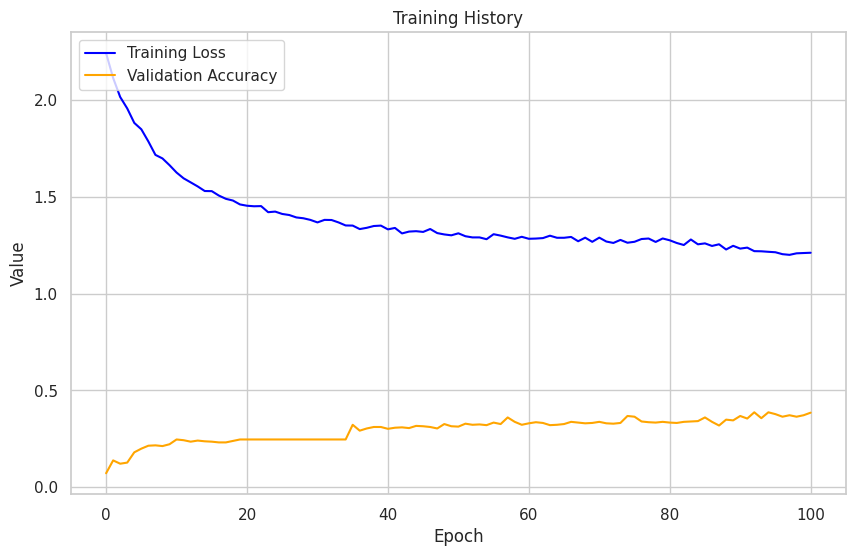

{0: 0, 1: 1, 2: 0, 3: 899, 4: 2, 5: 150, 6: 1209, 7: 0}

MLP test accuracy: 43.52%



In [47]:
mlp = MLP(dataset.num_features, 16, dataset.num_classes)
train(model=mlp, data=data, epochs=100, MLP=True)
MPL_acc = test(model=mlp, data=data, MLP=True)
print(f'\nMLP test accuracy: {MPL_acc*100:.2f}%\n')


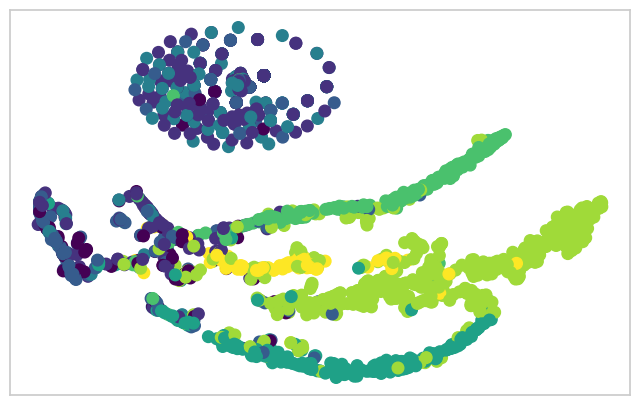

In [182]:
out = mlp(data.x)
visualize(out[data.test_mask], color=data.y[data.test_mask])

### **5.2 Modelo GCN (Graph Convolutional Network)**

Se construye un modelo XXX

In [39]:
class GCN(torch.nn.Module):
  def __init__(self, dim_input, dim_output):
      super().__init__()
      torch.manual_seed(42)
      self.conv1 = GCNConv(dim_input, 32)
      self.conv2 = GCNConv(32, 32)
      self.conv3 = GCNConv(32, 16)
      self.conv4 = GCNConv(16, 8)
      self.conv5 = GCNConv(8, dim_output)
      self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
      x = self.conv1(x, edge_index)
      x = F.relu(x)
      x = self.conv2(x, edge_index)
      x = F.relu(x)
      x = self.conv3(x, edge_index)
      x = F.relu(x)
      x = self.conv4(x, edge_index)
      x = F.relu(x)
      x = self.conv5(x, edge_index)
      return x, F.log_softmax(x, dim=1)

Epoch   0 | Train Loss: 2.199 | Train Acc:   8.91% | Val Loss: 2.20 | Val Acc: 10.44%
Epoch  10 | Train Loss: 1.765 | Train Acc:  25.45% | Val Loss: 1.74 | Val Acc: 24.67%
Epoch  20 | Train Loss: 1.439 | Train Acc:  25.45% | Val Loss: 1.39 | Val Acc: 24.67%
Epoch  30 | Train Loss: 1.200 | Train Acc:  35.93% | Val Loss: 1.17 | Val Acc: 33.78%
Epoch  40 | Train Loss: 1.040 | Train Acc:  49.92% | Val Loss: 1.03 | Val Acc: 48.77%
Epoch  50 | Train Loss: 1.000 | Train Acc:  57.15% | Val Loss: 0.99 | Val Acc: 58.63%
Epoch  60 | Train Loss: 0.838 | Train Acc:  64.79% | Val Loss: 0.85 | Val Acc: 64.90%
Epoch  70 | Train Loss: 0.788 | Train Acc:  65.76% | Val Loss: 0.80 | Val Acc: 66.60%
Epoch  80 | Train Loss: 0.616 | Train Acc:  74.27% | Val Loss: 0.62 | Val Acc: 77.04%
Epoch  90 | Train Loss: 0.515 | Train Acc:  82.40% | Val Loss: 0.53 | Val Acc: 82.54%
Epoch 100 | Train Loss: 0.431 | Train Acc:  86.41% | Val Loss: 0.45 | Val Acc: 86.53%


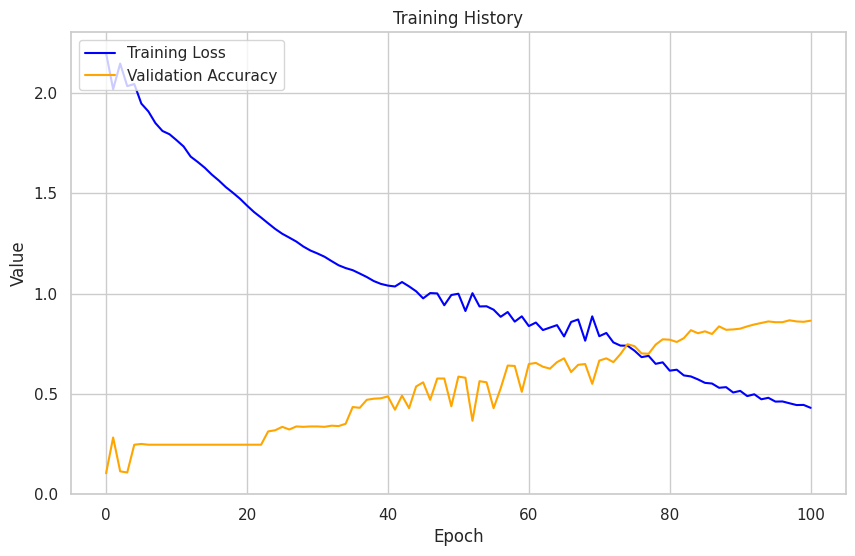

{0: 101, 1: 487, 2: 205, 3: 308, 4: 233, 5: 241, 6: 577, 7: 109}

GCN test accuracy: 87.04%

CPU times: user 30.5 s, sys: 126 ms, total: 30.7 s
Wall time: 30.8 s


In [48]:
%%time
gcn = GCN(data.num_features, data.num_classes)
train(gcn, data, 100)
GCN_acc = test(gcn, data)
print(f'\nGCN test accuracy: {GCN_acc *100:.2f}%\n')

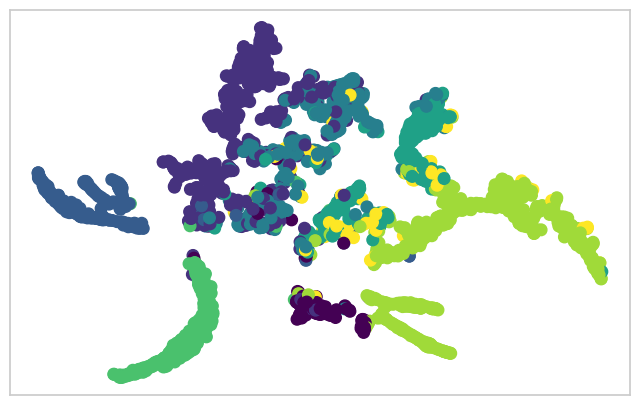

In [186]:
out,_ = gcn(data.x, data.edge_index)
visualize(out[data.test_mask], color=data.y[data.test_mask])

### **5.3 Modelo  GATv2Conv**

Se construye un modelo XXX

In [41]:
class GAT(torch.nn.Module):
  def __init__(self, dim_input, dim_hidden, dim_output, heads=8):
    super().__init__()
    torch.manual_seed(42)
    self.gat1 = GATv2Conv(dim_input, dim_hidden, heads=heads)
    self.gat2 = GATv2Conv(dim_hidden*heads, dim_output, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    x = self.gat1(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.gat2(x, edge_index)
    return x, F.log_softmax(x, dim=1)

Epoch   0 | Train Loss: 2.342 | Train Acc:  11.87% | Val Loss: 2.33 | Val Acc: 12.52%
Epoch  10 | Train Loss: 1.495 | Train Acc:  31.55% | Val Loss: 1.48 | Val Acc: 31.12%
Epoch  20 | Train Loss: 0.826 | Train Acc:  67.37% | Val Loss: 0.88 | Val Acc: 65.28%
Epoch  30 | Train Loss: 0.477 | Train Acc:  82.46% | Val Loss: 0.50 | Val Acc: 83.68%
Epoch  40 | Train Loss: 0.331 | Train Acc:  86.61% | Val Loss: 0.37 | Val Acc: 87.29%
Epoch  50 | Train Loss: 0.271 | Train Acc:  90.71% | Val Loss: 0.35 | Val Acc: 89.37%
Epoch  60 | Train Loss: 0.206 | Train Acc:  93.48% | Val Loss: 0.29 | Val Acc: 92.79%
Epoch  70 | Train Loss: 0.187 | Train Acc:  94.05% | Val Loss: 0.28 | Val Acc: 93.17%
Epoch  80 | Train Loss: 0.158 | Train Acc:  94.50% | Val Loss: 0.26 | Val Acc: 92.41%
Epoch  90 | Train Loss: 0.134 | Train Acc:  95.68% | Val Loss: 0.25 | Val Acc: 94.31%
Epoch 100 | Train Loss: 0.135 | Train Acc:  95.68% | Val Loss: 0.20 | Val Acc: 93.74%


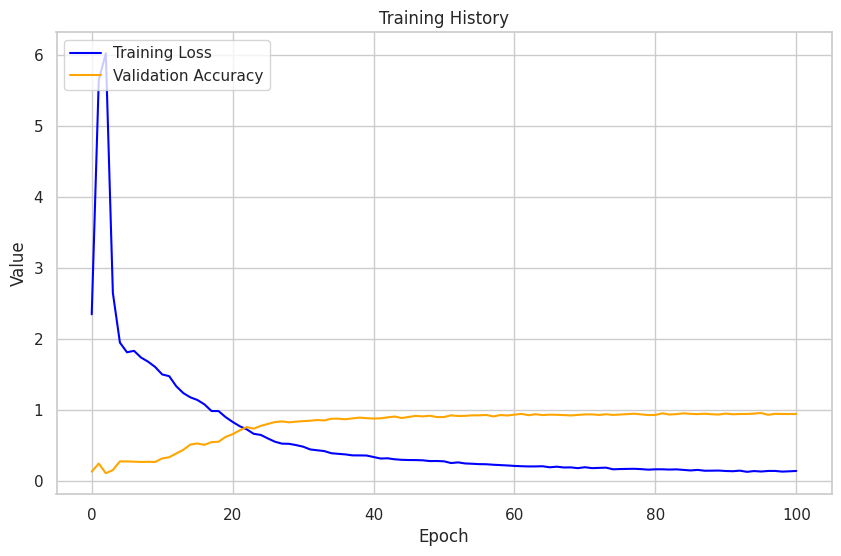

{0: 103, 1: 484, 2: 204, 3: 302, 4: 252, 5: 237, 6: 600, 7: 79}

GAT test accuracy: 94.60%

CPU times: user 1min 33s, sys: 1min 36s, total: 3min 10s
Wall time: 3min 11s


In [49]:
%%time
gat = GAT(data.num_features, 16, data.num_classes)
train(gat, data, 100)
GAT_acc = test(gat, data)
print(f'\nGAT test accuracy: {GAT_acc*100:.2f}%\n')

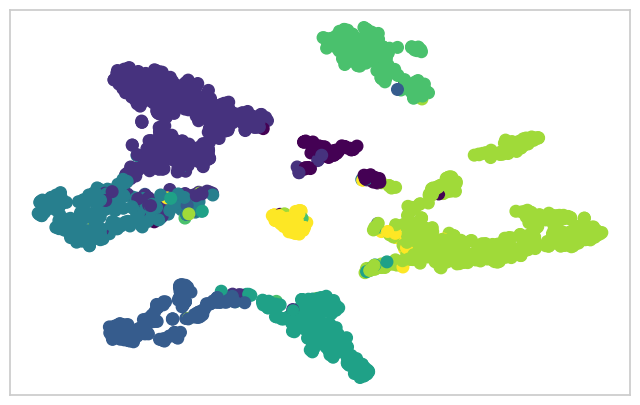

In [189]:
out,_ = gat(data.x, data.edge_index)
visualize(out[data.test_mask], color=data.y[data.test_mask])

### **5.4 Modelo  GATConv**

Se construye un modelo XXX

In [43]:
class GATc(torch.nn.Module):
  def __init__(self, dim_input, dim_output):
    super().__init__()
    torch.manual_seed(42)
    self.conv1 = GATConv(in_channels=dim_input, out_channels=32, heads=32)
    self.conv2 = GATConv(in_channels=32 * 32, out_channels=16, heads=16)
    self.conv3 = GATConv(in_channels=16 * 16, out_channels=8, heads=8)
    self.conv4 = GATConv(in_channels=8 * 8, out_channels=4, heads=4)
    self.conv5 = GATConv(in_channels=4 * 4, out_channels=dim_output)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    x = F.relu(x)
    x = self.conv3(x, edge_index)
    x = F.relu(x)
    x = self.conv4(x, edge_index)
    x = F.relu(x)
    x = self.conv5(x, edge_index)
    return x, F.log_softmax(x, dim=1)

Epoch   0 | Train Loss: 2.143 | Train Acc:  11.74% | Val Loss: 2.14 | Val Acc: 11.20%
Epoch  10 | Train Loss: 2.007 | Train Acc:   8.97% | Val Loss: 2.00 | Val Acc: 7.02%
Epoch  20 | Train Loss: 2.009 | Train Acc:  25.45% | Val Loss: 2.01 | Val Acc: 24.67%
Epoch  30 | Train Loss: 1.964 | Train Acc:  25.45% | Val Loss: 1.97 | Val Acc: 24.67%
Epoch  40 | Train Loss: 1.921 | Train Acc:  25.45% | Val Loss: 1.92 | Val Acc: 24.67%
Epoch  50 | Train Loss: 1.882 | Train Acc:  25.45% | Val Loss: 1.88 | Val Acc: 24.67%
Epoch  60 | Train Loss: 1.849 | Train Acc:  25.45% | Val Loss: 1.85 | Val Acc: 24.67%


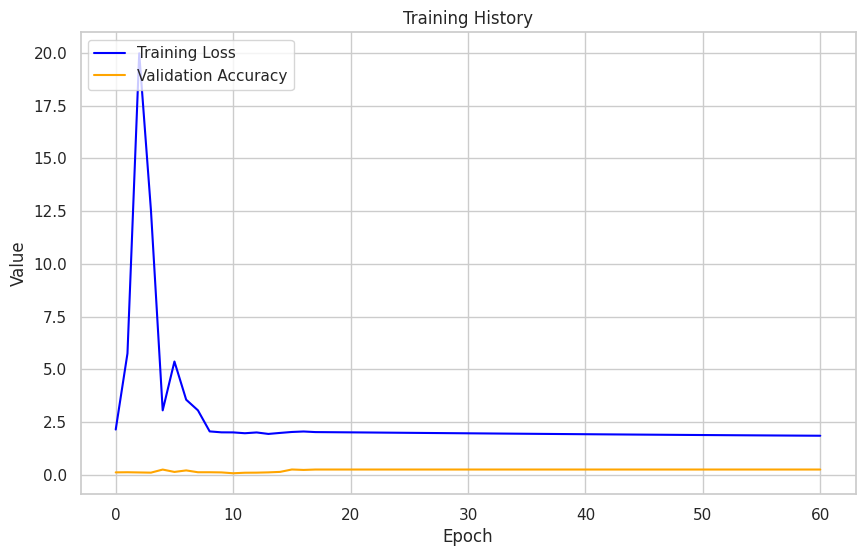

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 2261, 7: 0}

GATC test accuracy: 25.17%

CPU times: user 3min 40s, sys: 4min 21s, total: 8min 1s
Wall time: 8min 42s


In [44]:
%%time
gat2 = GATc(data.num_features, data.num_classes)
train(gat2, data, 60)
GAT2_acc = test(gat2, data)
print(f'\nGATC test accuracy: {GAT2_acc*100:.2f}%\n')

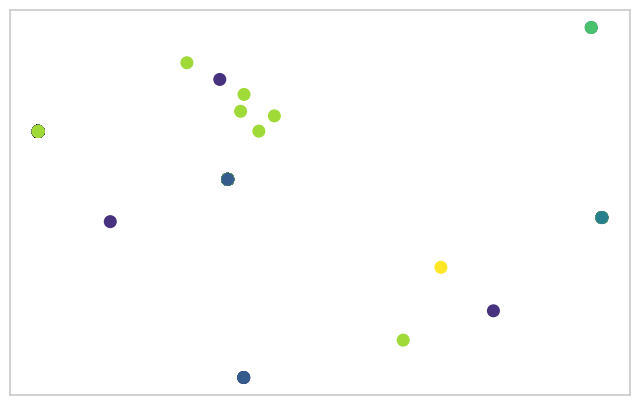

In [192]:
out,_ = gat2(data.x, data.edge_index)
visualize(out[data.test_mask], color=data.y[data.test_mask])

### **5.5 Modelo  GraphSAGE**

Se construye un modelo XXX

In [193]:
def test(model, data, MLP=False):
    model.eval()
    if MLP:
      out = model(data.x)
    else:
      _, out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    # Count the number of predictions for each class
    class_counts = {}
    for class_label in range(data.num_classes):
        class_counts[class_label] = int((pred == class_label)[data.test_mask].sum())

    print(class_counts)

    test_acc = accuracy(pred[data.test_mask], data.y[data.test_mask])
    return test_acc


def train(model, data, epochs=10, plot=True, plot_name = "plot", MLP=False):
    weight = torch.tensor([1 / i for i in df_agg_classes["proportion"].values], dtype=torch.float)
    criterion = torch.nn.CrossEntropyLoss(weight=weight)
    optimizer = model.optimizer

    history = {
            'epoch': [],
            'loss': [],
            'test_acc': [],
            'outputs' : []
    }

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        if MLP:
          out = model(data.x)
        else:
          _, out = model(data.x, data.edge_index)

        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        history['epoch'].append(epoch)
        history['loss'].append(loss.item())
        history['test_acc'].append(val_acc)
        history['outputs'].append(out[data.train_mask].argmax(dim=1))

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    if plot:
        history_plot(history, plot_name)

    return model

In [194]:
data

Data(x=[7535, 745], edge_index=[2, 238162], y=[7535], train_mask=[7535], test_mask=[7535], val_mask=[7535], num_classes=8)

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


Subgraph 0: Data(x=[7253, 745], edge_index=[2, 93197], y=[7253], train_mask=[7253], test_mask=[7253], val_mask=[7253], num_classes=8, n_id=[7253], e_id=[93197], input_id=[1318], batch_size=1318)
Subgraph 1: Data(x=[7224, 745], edge_index=[2, 92875], y=[7224], train_mask=[7224], test_mask=[7224], val_mask=[7224], num_classes=8, n_id=[7224], e_id=[92875], input_id=[1318], batch_size=1318)
Subgraph 2: Data(x=[7243, 745], edge_index=[2, 94095], y=[7243], train_mask=[7243], test_mask=[7243], val_mask=[7243], num_classes=8, n_id=[7243], e_id=[94095], input_id=[1318], batch_size=1318)
Subgraph 3: Data(x=[7252, 745], edge_index=[2, 91871], y=[7252], train_mask=[7252], test_mask=[7252], val_mask=[7252], num_classes=8, n_id=[7252], e_id=[91871], input_id=[1318], batch_size=1318)
Subgraph 4: Data(x=[301, 745], edge_index=[2, 353], y=[301], train_mask=[301], test_mask=[301], val_mask=[301], num_classes=8, n_id=[301], e_id=[353], input_id=[2], batch_size=2)


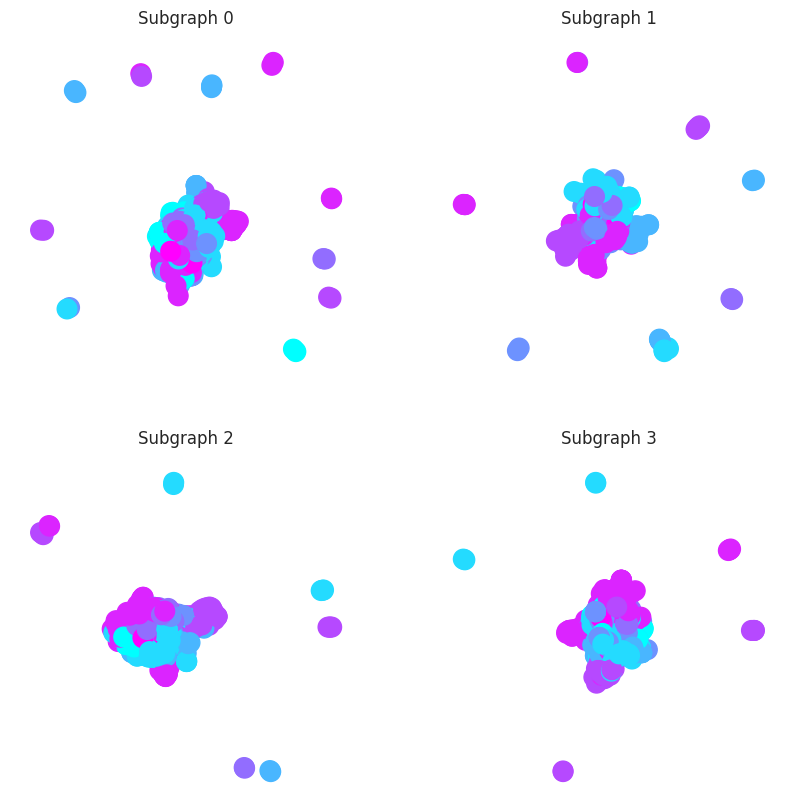

In [195]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

batch_size = len(data.train_mask.nonzero(as_tuple=False)) // 4

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 50],
    batch_size=batch_size,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

# Plot each subgraph
fig = plt.figure(figsize=(10,10))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}')
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=200,
                    node_color=subdata.y,
                    cmap="cool",
                    font_size=10
                    )
plt.show()

Creamos cuatro subgrafos de varios tamaños. Nos permite procesarlos en paralelo y es más fácil procesarlos.

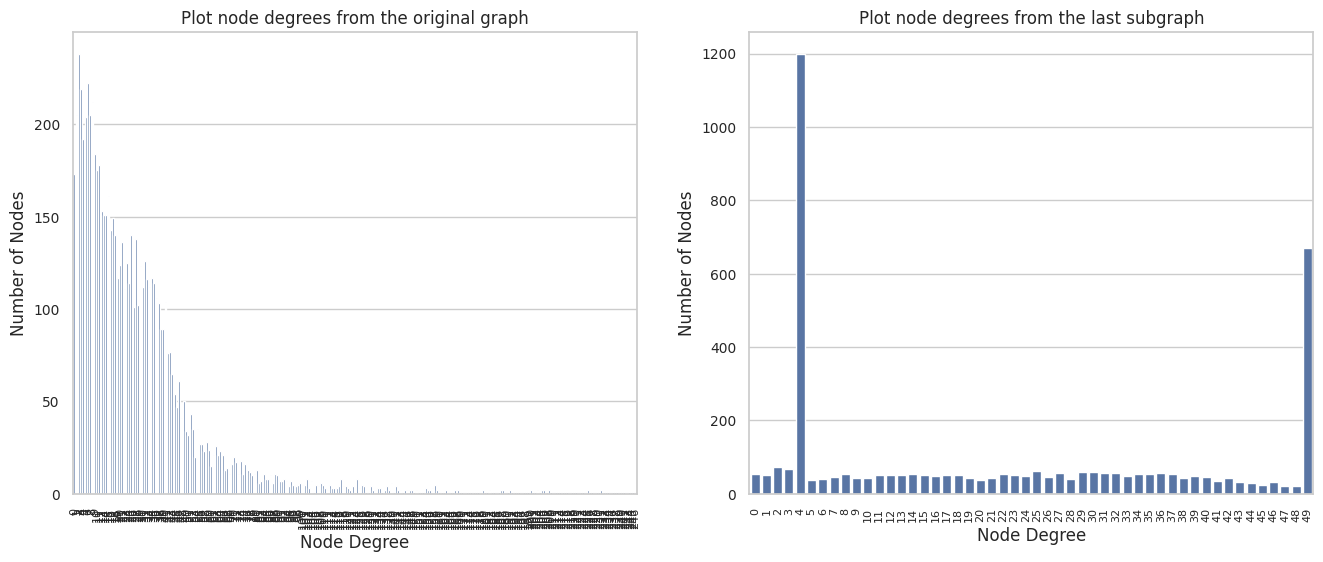

In [196]:
from torch_geometric.utils import degree
from collections import Counter
import seaborn as sns
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

def plot_degree(data, index, title):
    # Obtener lista de grados para cada nodo
    degrees = degree(data.edge_index[index]).numpy()
    # Contar el número de nodos para cada grado
    numbers = Counter(degrees)
    # Convertir los datos a un DataFrame de pandas
    degree_df = pd.DataFrame.from_dict(numbers, orient='index').reset_index()
    degree_df.columns = ['Degree', 'Count']
    sns.barplot(ax=axes[index], x='Degree', y='Count', data=degree_df)
    axes[index].set_xlabel('Node Degree')
    axes[index].set_ylabel('Number of Nodes')
    axes[index].set_title(title)
    axes[index].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    axes[index].tick_params(axis='x', labelsize=8)
    axes[index].tick_params(axis='y', labelsize=10)
    axes[index].set_xticks(range(len(degree_df)))
    axes[index].set_xticklabels(axes[index].get_xticklabels(), rotation=90)

plot_degree(data,0,'Plot node degrees from the original graph')
plot_degree(subdata,1,'Plot node degrees from the last subgraph')

El primer gráfico muestra la distribución original de los grados de los nodos, mientras que el segundo muestra la distribución obtenida después del muestreo de vecinos. En este ejemplo, elegimos considerar solo cinco vecinos, que es mucho menor que el valor máximo original. Es importante recordar este compromiso al hablar sobre GraphSAGE.

PinSAGE propone otra solución. En lugar de muestreo de vecinos, PinSAGE simula caminatas aleatorias para cada nodo, lo que captura una representación mejor de sus vecindarios. Luego, selecciona un número predefinido de vecinos con el mayor número de visitas. Esta técnica permite a PinSAGE considerar la importancia de cada vecino mientras controla el tamaño del grafo de computación.

In [197]:
class GraphSAGE(torch.nn.Module):
  def __init__(self, dim_input, dim_hidden, dim_output):
    super().__init__()
    self.sage1 = SAGEConv(dim_input, dim_hidden)
    self.sage2 = SAGEConv(dim_hidden, dim_output)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index).relu()
    h = F.dropout(h, p=0.1, training=self.training)
    h = self.sage2(h, edge_index)
    return F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    weight = torch.tensor([1 / i for i in df_agg_classes["proportion"].values], dtype=torch.float)
    criterion = torch.nn.CrossEntropyLoss(weight=weight)
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        out = self(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1),
                        batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1),
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {total_loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')

In [198]:
@torch.no_grad()
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

Con GraphSAGE, recorremos lotes (nuestros cuatro subgrafos) creados por el proceso de muestreo vecino. La forma en que calculamos la precisión y la pérdida de validación también es diferente por eso.

In [199]:
%%time

# Create GraphSAGE
graphsage = GraphSAGE(data.num_features, 64, data.num_classes)
print(graphsage)

# Train
graphsage.fit(data, 10)

# Test
print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')

GraphSAGE(
  (sage1): SAGEConv(745, 64, aggr=mean)
  (sage2): SAGEConv(64, 8, aggr=mean)
)
Epoch   0 | Train Loss: 3.109 | Train Acc:  21.26% | Val Loss: 2.81 | Val Acc: 23.61%
Epoch  10 | Train Loss: 0.531 | Train Acc:  78.75% | Val Loss: 0.67 | Val Acc: 72.75%

GraphSAGE test accuracy: 89.03%

CPU times: user 13.8 s, sys: 8.92 s, total: 22.7 s
Wall time: 22.8 s


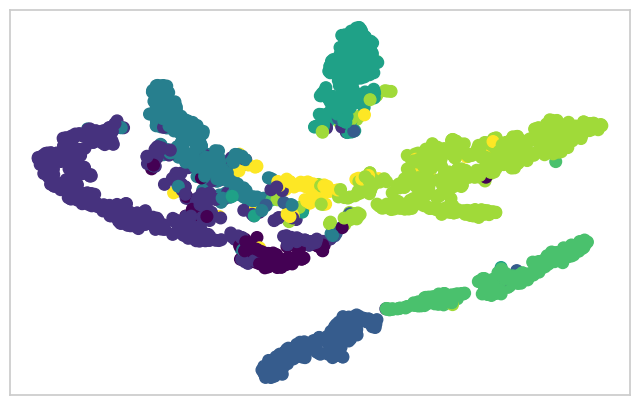

In [200]:
out = graphsage(data.x, data.edge_index)
visualize(out[data.test_mask], color=data.y[data.test_mask])

## **6. Conclusiones**


Los 5 modelos trabajados reflejan los siguientes resultados siendo el mejor GAT con un accuracy  de 94%

In [52]:
print(f'\nMLP test accuracy: {MPL_acc*100:.2f}%\n')

print(f'\nGCN test accuracy: {GCN_acc *100:.2f}%\n')

print(f'\nGAT test accuracy: {GAT_acc*100:.2f}%\n')

print(f'\nGATC test accuracy: {GAT2_acc*100:.2f}%\n')

print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')



MLP test accuracy: 43.52%


GCN test accuracy: 87.04%


GAT test accuracy: 94.60%



NameError: name 'GAT2_acc' is not defined